# Covid 19 Analysis

In [1]:
%matplotlib inline

# Packages used in the notebook
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sb
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, learning_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import clone
from sklearn.datasets import load_iris, load_digits
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# function used to call train_test_split to split the data in 75% for training and 25% for testing
def split_train_test(inputs, outputs):
    return train_test_split(inputs, outputs, test_size=0.25, shuffle=True)

# function used to train the model (search) with the training data (in_train, out_train), also gives the time elapsed
def train_model(params, search, in_train, out_train):
    start = time.time()
    search.fit(in_train, out_train)
    end = time.time()
    elapsed_time = end - start
    print('Elapsed time: {}mins'.format(elapsed_time / 60))
    print('Best score: {}'.format(search.best_score_))
    print('Best parameters: {}'.format(search.best_params_))
    return search.best_estimator_
    
# function used to plot a bar graph to compare the data ploted using the trained model (estimator) with the actual real results (out_test)
# Also gives some statistical parameters like the Mean Absolute Error (MAE),Mean Squared Error (MSE), Root Mean Squared Error (RMSE)
# and finally the (R^2).
def check_results_test(estimator, in_test, out_test, label):
    estimator_pred = estimator.predict(in_test)
    plt.plot(out_test)
    plt.plot(estimator_pred)
    plt.legend(['Input Data', label])
    print('MAE:', mean_absolute_error(out_test, estimator_pred))
    print('MSE:',mean_squared_error(out_test, estimator_pred))
    print('RMSE:', math.sqrt(mean_squared_error(out_test, estimator_pred)))
    print('R^2:', r2_score(out_test, estimator_pred))
    
# function used to calculate and plot the cross validation score when using a trained model (estimator) and applying it
# to the inputs (inputs) and finally comparing it with the outputs (outputs).
def plot_cross_val_score(estimator, inputs, outputs, number_cv):
    cv_scores = cross_val_score(estimator, inputs, outputs, cv=number_cv)
    plt.hist(cv_scores)
    plt.title('Average score: {}'.format(np.mean(cv_scores)))
    
# function used to convert data from increments into cumulative data    
def calc_cumulative(in_list):
    out_list = []
    for idx, elem in enumerate(in_list):
        if idx == 0:
            out_list.append(elem)
        else:
            out_list.append(elem + out_list[idx - 1])
    return out_list
    
# function used to predict  a attribute (output), for a certain country (country) using as input an array of 
# attributes (inputs_list). This prediction is done using a trained model (estimator) and using input and output data 
# from the certain country (country_inputs, country_outputs). When cumulative is True it means we are predicting
# a cumulative attribute and otherwise a incremental attribute. 
def plot_predictions_for_country(df, country, estimator, inputs_list, output, label_out, label_pred, title, cumulative=False):
    country_df = df.loc[df["Country/Region"] == country]
    country_inputs = country_df[inputs_list].values
    country_outputs = country_df[output].values
    days_list = df["Num_days_from_begin"].unique()
    country_pred_output = estimator.predict(country_inputs) 

    first_day = df["Date"].min()
    last_day = df["Date"].max()

    if cumulative:
        country_pred_output = calc_cumulative(country_pred_output)
    
    print('MAE:', mean_absolute_error(country_outputs, country_pred_output))
    print('MSE:',mean_squared_error(country_outputs, country_pred_output))
    print('RMSE:', math.sqrt(mean_squared_error(country_outputs, country_pred_output)))
    print('R^2:', r2_score(country_outputs, country_pred_output))

    plt.plot(days_list, country_outputs, color='blue', label=label_out)
    plt.plot(days_list, country_pred_output, color='green', label=label_pred)
    plt.xlabel("Number of days since {}".format(first_day))
    plt.ylabel("# of Cases")
    plt.title(title + "(as of {})".format(last_day))
    plt.legend()

    
# function used to plot a learning curve using a trained model (estimator) and inputs (inputs) and outputs(outputs)
# to test the model itself
def plot_learning_curve(estimator, inputs, outputs):
    train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=inputs, y=outputs,
                                       groups=None, 
                                       train_sizes=np.array([0.1, 0.33, 0.55, 0.78, 1. ]),
                                       cv=None, scoring=None, exploit_incremental_learning=False, 
                                       n_jobs=None, pre_dispatch='all', verbose=0, shuffle=True,
                                       random_state=None, error_score=np.nan, return_times=False)

    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)

    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, test_scores_mean, label='Test score')

    plt.ylabel('Score', fontsize=14)
    plt.xlabel('Training set size', fontsize=14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize=18, y=1.03)
    plt.legend()
    
    
# function used to plot a bar graph representing the diference between the actual output values  for a country (country_outputs),
# obtained using the "output" variable ,and the ones predicted by a trained model (estimator) for a certain attribute (output) using 
# as input an array of values (country_inputs) obtained from the array "inputs_list" for that certain country
def plot_pred_diff(df, estimator, country, inputs_list, output):
    country_df = df.loc[df["Country/Region"] == country]
    country_inputs = country_df[inputs_list].values
    country_outputs = country_df[output].values
    days_list = df["Num_days_from_begin"].unique()
    country_pred_output = estimator.predict(country_inputs)

    first_day = df["Date"].min()
    last_day = df["Date"].max()

    diff_list = np.subtract(country_outputs, country_pred_output)
    plt.bar(days_list, diff_list, color='blue', label="")
    plt.show()

## 3) Prediction and Regression
### 3.4) K-Nearest Neighbour
- - -

In [3]:
# load previously processed information into dataframe
df = pd.read_csv('data/covid_19_world_processed.csv', delimiter=',')
df

,Country/Region,Lat,Lat_norm,Long,Long_norm,Date,Num_days_from_begin,Num_days_from_begin_norm,Confirmed,Deaths,...,Confirmed_inc_day_before,Confirmed_inc_day_before_norm,Deaths_inc,Deaths_inc_norm,Deaths_inc_day_before,Deaths_inc_day_before_norm,Recovered_inc,Recovered_inc_norm,Recovered_inc_day_before,Recovered_inc_day_before_norm
0,Afghanistan,33.0000,0.471083,65.0000,0.597360,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
1,Albania,41.1533,0.798304,20.1683,-0.039787,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
2,Alberta (Canada),53.9333,1.311212,-116.5765,-1.983201,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,NaN,NaN,NaN,NaN
3,Algeria,28.0339,0.271776,1.6596,-0.302833,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
4,Andorra,42.5063,0.852605,1.5218,-0.304791,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30619,Yukon (Canada),64.2823,1.726554,-135.0000,-2.245035,2020-05-16,115,1.717183,11,0,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,NaN,NaN,NaN,NaN
30620,Yunnan (China),24.9740,0.148971,101.4870,1.115912,2020-05-16,115,1.717183,185,2,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,0.0,-0.121130,0.0,-0.121373
30621,Zambia,-15.4167,-1.472053,28.2833,0.075543,2020-05-16,115,1.717183,679,7,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,59.0,0.003578,0.0,-0.121373
30622,Zhejiang (China),29.1832,0.317901,120.0934,1.380346,2020-05-16,115,1.717183,1268,1,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,0.0,-0.121130,0.0,-0.121373


### Approach (k nearest neighbours)

#### Brief description of the algorithm

k nearest neighbours provides functionality for unsupervised and supervised neighbors-based learning methods.

The principle behind nearest neighbor methods is to find a predefined number of training samples closest in distance to the new point, and predict the label from these. The number of samples can be a user-defined constant (k-nearest neighbor learning), or vary based on the local density of points (radius-based neighbor learning). The distance can, in general, be any metric measure: standard Euclidean distance is the most common choice. Neighbors-based methods are known as non-generalizing machine learning methods, since they simply “remember” all of its training data (possibly transformed into a fast indexing structure such as a Ball Tree or KD Tree).

#### Steps taken to make the algorith start predicting values

In order to make KNeighborsRegressor start predicting values the first step needed was to do hyper parameter tuning using cross validation, for that reason, function RandomizedSearchCV() was used from sktlearn. The scoring value used by RandomizedSearchCV() to evaluate parameters was the negative mean squared error (scoring='neg_mean_squared_error'). For the cross validation part of this function, times of processing were evaluated and it was decided to use a 3-fold strategy with 10 iterations.

After that the model was trained using training data and at the end the model was ready to be tested and used to predict
values.
It was decided it would be in the best of interests to predict values for the confimed cases first, using the following combinations of inputs and outputs:

1) inputs: lat_norm, long_norm, num_days_from_begin_norm
    outputs: confirmed_inc

2) inputs: lat, long, num_days_from_begin
     outputs: confirmed_inc

3) inputs: lat_norm, long_norm, num_days_from_begin_norm, confirmed_inc_day_before_norm
    outputs: confirmed_inc
    
From this three combinations, one was chosen, the one with the best predictions, and used to predict the deaths and the recovered number of cases. In order to find out which combination was the best, a number of scalar parameters like the MSA, MSE, RMSE and R^2 were used to compare iterations. In the end it was discovered that the best combination was the third one using as input the normalized values of the lat, long, num_days_from_begin and confirmed_inc_day_before and as output the increment in confirmed cases.

In order to compare values in a consistent way all the graphs related to countries were made always for the same 6 countries: US, Spain, Portugal, Italy, Russia and Brazil

### 3.4.1) Regression for confirmed cases

### Using normalized values as input and using increments as output

In [21]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.71718314],
       [ 0.79830423, -0.03978737, -1.71718314],
       [ 1.3112115 , -1.98320106, -1.71718314],
       ...,
       [-1.47205293,  0.07554281,  1.71718314],
       [ 0.31790115,  1.38034566,  1.71718314],
       [-1.65599721,  0.09994051,  1.71718314]])

In [22]:
# get the output for the machine learning algorithm (confirmed inc cases)
outputs = df["Confirmed_inc"].values
outputs

array([ 0.,  0.,  0., ..., 25.,  0.,  0.])

In [23]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [24]:
# create K-Nearest Neighbours instance, and check the hyper parameters
knn = KNeighborsRegressor()
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [25]:
# do hyper parameter tuning with the K-Nearest, using cross validation
leaf_size = list(range(10,50))
n_neighbors = list(range(10,30))
p=[1,2]

param_grid = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

search = RandomizedSearchCV(knn, param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
knn_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
knn_estimator

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Elapsed time: 0.15884426832199097mins
Best score: -228638.38324791085
Best parameters: {'p': 2, 'n_neighbors': 11, 'leaf_size': 48}


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.5s finished


KNeighborsRegressor(algorithm='auto', leaf_size=48, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                    weights='uniform')

MAE: 88.17290063645864
MSE: 200574.31270564007
RMSE: 447.8552363271418
R^2: 0.8954067463205594


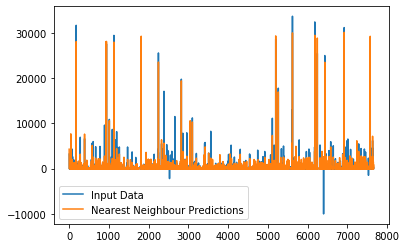

In [26]:
# The values MAE, MSE, RMSE AN R^2 are used to compare inputs and outputs combinations
# and find the best,the one able to predict the output more accurately that the others
check_results_test(knn_estimator, in_conf_test, out_conf_test, 'Nearest Neighbour Predictions')

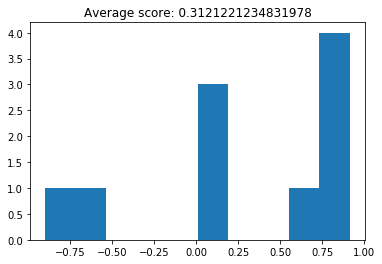

In [27]:
knn_estimator_2 = clone(knn_estimator)

plot_cross_val_score(knn_estimator_2, inputs, outputs, 10)

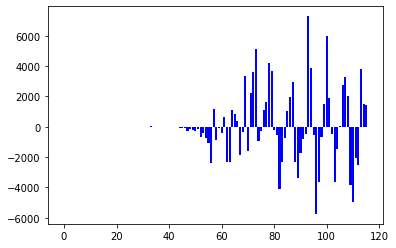

In [28]:
plot_pred_diff(
    df, knn_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed_inc"
)

MAE: 3456.1998432601363
MSE: 27373280.529138707
RMSE: 5231.948062542165
R^2: 0.9998820205699331


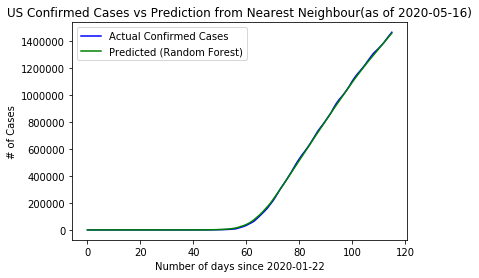

In [29]:
plot_predictions_for_country(
    df, "US", knn_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (KNN)", 
    "US Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 38920.01253918495
MSE: 3334311706.5998855
RMSE: 57743.499258357086
R^2: 0.6149553611585745


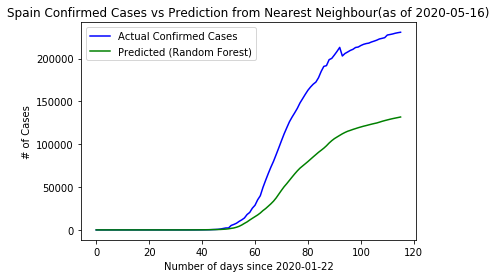

In [30]:
plot_predictions_for_country(
    df, "Spain", knn_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (KNN)", 
    "Spain Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 2664.366771159874
MSE: 49917244.40068397
RMSE: 7065.213684007297
R^2: 0.9832809763347056


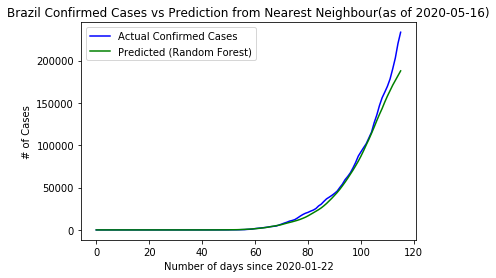

In [31]:
plot_predictions_for_country(
    df, "Brazil", knn_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (KNN)", 
    "Brazil Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 33354.31269592476
MSE: 2589600041.4906664
RMSE: 50888.11296845921
R^2: -21.558669456230422


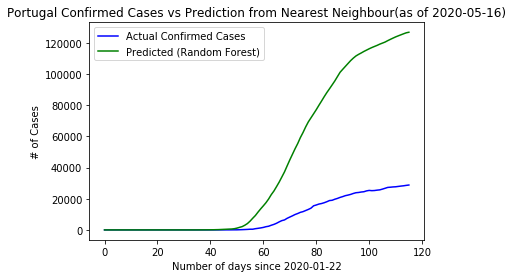

In [32]:
plot_predictions_for_country(
    df, "Portugal", knn_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (KNN)", 
    "Portugal Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 1310.3926332288424
MSE: 5900711.84746368
RMSE: 2429.13808736014
R^2: 0.9987712961269565


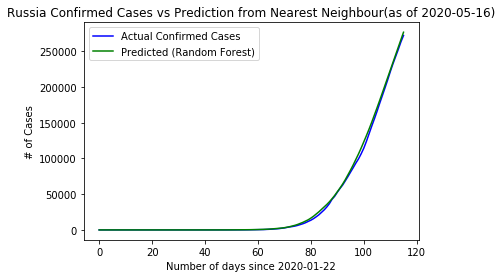

In [33]:
plot_predictions_for_country(
    df, "Russia", knn_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (KNN)", 
    "Russia Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 54582.532131661435
MSE: 6179042007.176047
RMSE: 78606.88269595765
R^2: 0.18090357634227694


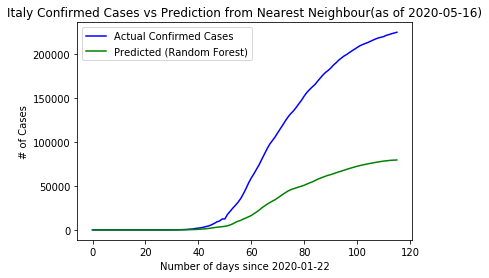

In [34]:
plot_predictions_for_country(
    df, "Italy", knn_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (KNN)", 
    "Italy Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

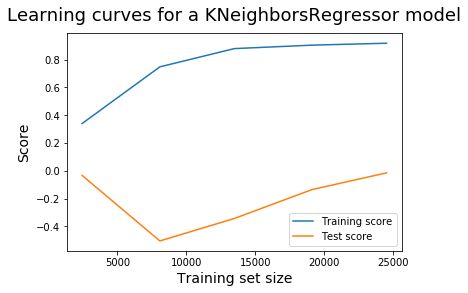

In [35]:
# learning curve
knn_estimator_2 = clone(knn_estimator)

plot_learning_curve(knn_estimator_2, inputs, outputs)

### Using non normalized values and increment in confirmed values as output

In [36]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat", "Long", "Num_days_from_begin"]].values
inputs

array([[  33.    ,   65.    ,    0.    ],
       [  41.1533,   20.1683,    0.    ],
       [  53.9333, -116.5765,    0.    ],
       ...,
       [ -15.4167,   28.2833,  115.    ],
       [  29.1832,  120.0934,  115.    ],
       [ -20.    ,   30.    ,  115.    ]])

In [37]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = df["Confirmed_inc"].values
outputs

array([ 0.,  0.,  0., ..., 25.,  0.,  0.])

In [38]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [39]:
# do hyper parameter tuning with the K-Nearest, using cross validation
leaf_size = list(range(10,50))
n_neighbors = list(range(10,30))
p=[1,2]

param_grid = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

search = RandomizedSearchCV(KNeighborsRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
knn_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
knn_estimator

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Elapsed time: 0.08176754713058472mins
Best score: -208595.7440638351
Best parameters: {'p': 1, 'n_neighbors': 14, 'leaf_size': 47}


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.9s finished


KNeighborsRegressor(algorithm='auto', leaf_size=47, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=14, p=1,
                    weights='uniform')

MAE: 57.94818256456187
MSE: 91099.51332288401
RMSE: 301.82695923804425
R^2: 0.9501538534731411


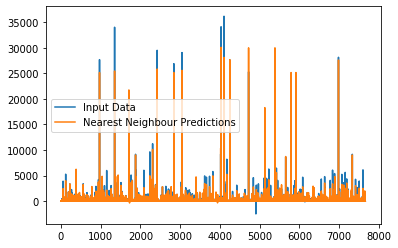

In [40]:
check_results_test(knn_estimator, in_conf_test, out_conf_test, 'Nearest Neighbour Predictions')

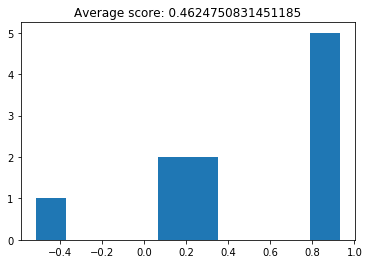

In [41]:
knn_estimator_2 = clone(knn_estimator)

plot_cross_val_score(knn_estimator_2, inputs, outputs, 10)

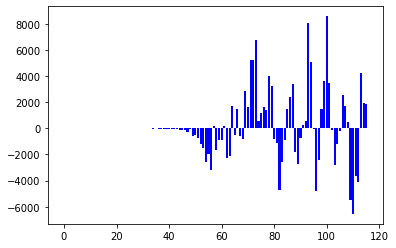

In [42]:
plot_pred_diff(
    df, knn_estimator,
    "US", 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed_inc"
)

MAE: 8159.266625615796
MSE: 149397964.38357773
RMSE: 12222.846001794253
R^2: 0.9993560915480206


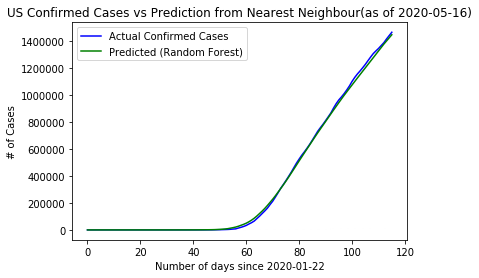

In [43]:
plot_predictions_for_country(
    df, "US", knn_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (KNN)", 
    "US Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 21095.477216748775
MSE: 1047510147.9555334
RMSE: 32365.261438084097
R^2: 0.8790340549733532


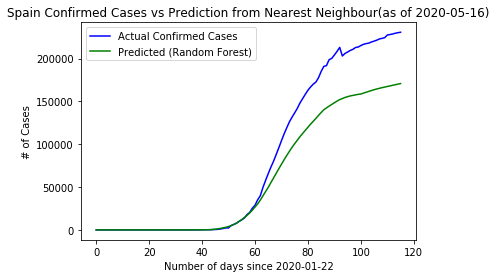

In [44]:
plot_predictions_for_country(
    df, "Spain", knn_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (KNN)", 
    "Spain Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 1184.437192118223
MSE: 5336466.6703905435
RMSE: 2310.0793645220383
R^2: 0.9982126314538691


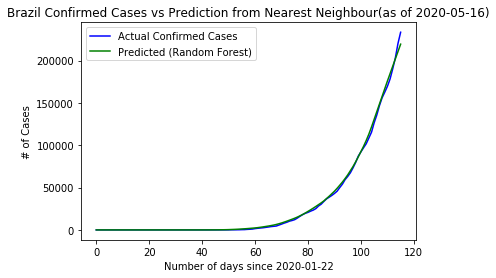

In [45]:
plot_predictions_for_country(
    df, "Brazil", knn_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (KNN)", 
    "Brazil Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 15549.443349753694
MSE: 544440485.6419774
RMSE: 23333.24850169769
R^2: -3.742760564336824


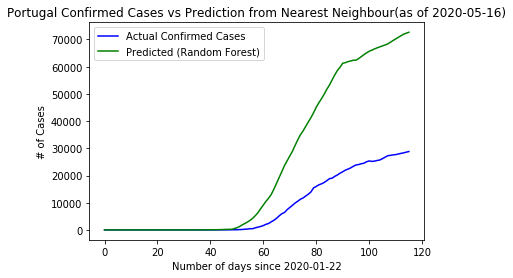

In [46]:
plot_predictions_for_country(
    df, "Portugal", knn_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (KNN)", 
    "Portugal Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 1370.418103448274
MSE: 6275616.344167825
RMSE: 2505.1180299873745
R^2: 0.9986932298496953


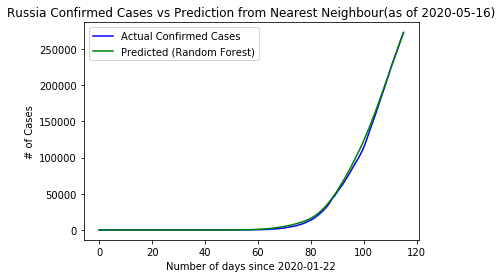

In [47]:
plot_predictions_for_country(
    df, "Russia", knn_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (KNN)", 
    "Russia Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 44727.961206896565
MSE: 4185636572.8321185
RMSE: 64696.4958311663
R^2: 0.4451502443977353


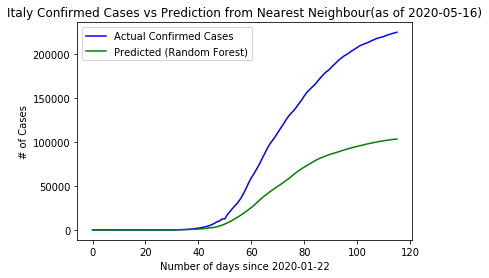

In [48]:
plot_predictions_for_country(
    df, "Italy", knn_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (KNN)", 
    "Italy Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

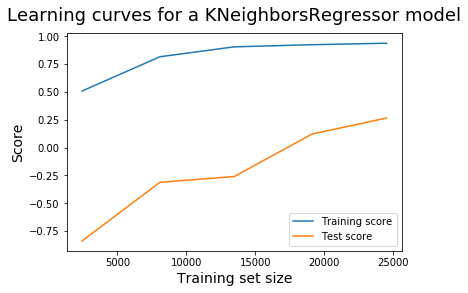

In [49]:
# learning curve
knn_estimator_2 = clone(knn_estimator)

plot_learning_curve(knn_estimator_2, inputs, outputs)

### Using increases in confirmed cases and normalized values, using increase as output

In [50]:
# get the inputs of the data for the machine learning algorithm
new_df = df.loc[df["Confirmed_inc_day_before_norm"].notna()]

inputs = new_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.68731909, -0.11699892],
       [ 0.79830423, -0.03978737, -1.68731909, -0.11699892],
       [ 1.3112115 , -1.98320106, -1.68731909, -0.11699892],
       ...,
       [-1.47205293,  0.07554281,  1.71718314, -0.11699892],
       [ 0.31790115,  1.38034566,  1.71718314, -0.11699892],
       [-1.65599721,  0.09994051,  1.71718314, -0.11308895]])

In [51]:
outputs = new_df["Confirmed_inc"].values
outputs

array([ 0.,  0.,  0., ..., 25.,  0.,  0.])

In [52]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [53]:
# do hyper parameter tuning with the K-Nearest, using cross validation
leaf_size = list(range(10,50))
n_neighbors = list(range(10,30))
p=[1,2]

param_grid = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

search = RandomizedSearchCV(KNeighborsRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
knn_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
knn_estimator

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Elapsed time: 0.20904228289922078mins
Best score: -138619.6050562997
Best parameters: {'p': 2, 'n_neighbors': 12, 'leaf_size': 18}


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.3s finished


KNeighborsRegressor(algorithm='auto', leaf_size=18, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=12, p=2,
                    weights='uniform')

MAE: 40.00935441370224
MSE: 81365.00938186211
RMSE: 285.2455247359056
R^2: 0.952175007897687


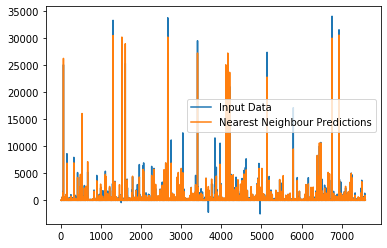

In [54]:
check_results_test(knn_estimator, in_conf_test, out_conf_test, 'Nearest Neighbour Predictions')

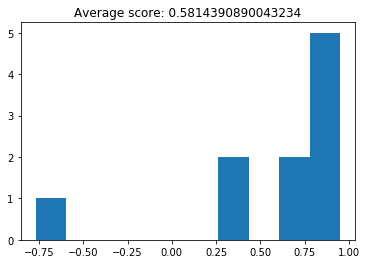

In [55]:
knn_estimator_2 = clone(knn_estimator)

plot_cross_val_score(knn_estimator_2, inputs, outputs, 10)

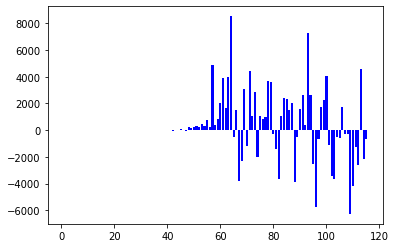

In [56]:
plot_pred_diff(
    new_df, knn_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed_inc"
)

MAE: 19156.6768115942
MSE: 782620681.7381641
RMSE: 27975.35847380984
R^2: 0.9966400581797187


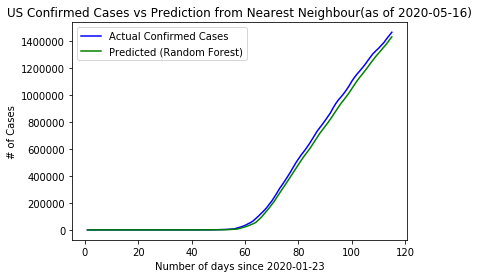

In [57]:
plot_predictions_for_country(
    new_df, "US", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (KNN)", 
    "US Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 6717.878260869589
MSE: 96427519.83961423
RMSE: 9819.751516184828
R^2: 0.9888848919902345


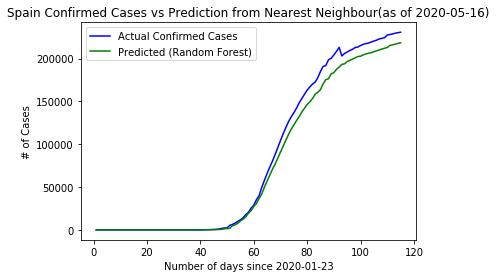

In [58]:
plot_predictions_for_country(
    new_df, "Spain", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (KNN)", 
    "Spain Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 3345.2405797101455
MSE: 55450622.315821275
RMSE: 7446.5174622652485
R^2: 0.9815381434435895


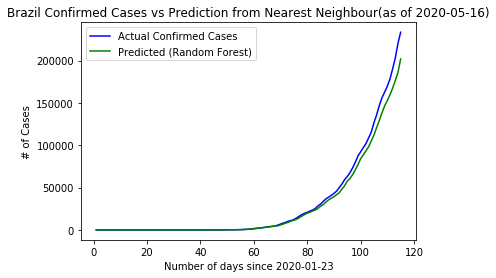

In [59]:
plot_predictions_for_country(
    new_df, "Brazil", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (KNN)", 
    "Brazil Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 562.331884057971
MSE: 892830.6155797109
RMSE: 944.8971455029965
R^2: 0.9922446959186233


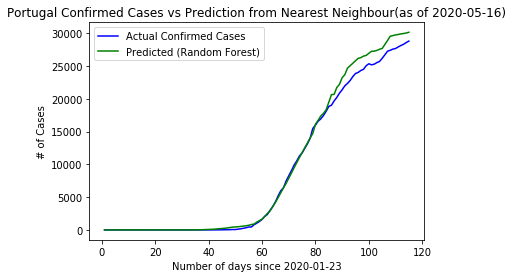

In [60]:
plot_predictions_for_country(
    new_df, "Portugal", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (KNN)", 
    "Portugal Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 2284.588405797114
MSE: 19731719.4293481
RMSE: 4442.0400076257865
R^2: 0.9959168210162408


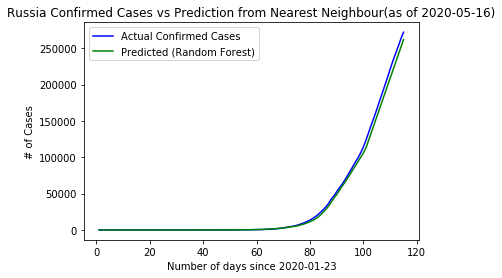

In [62]:
plot_predictions_for_country(
    new_df, "Russia", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (KNN)", 
    "Russia Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

In [ ]:
plot_predictions_for_country(
    new_df, "Italy", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (KNN)", 
    "Italy Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

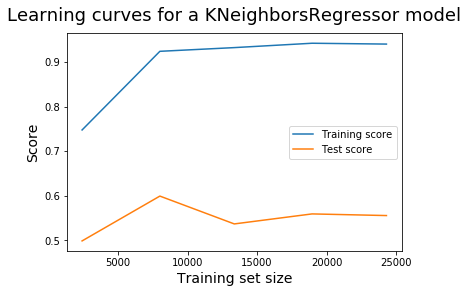

In [63]:
# learning curve
knn_estimator_2 = clone(knn_estimator)

plot_learning_curve(knn_estimator_2, inputs, outputs)

### Normalized inputs, cumulative as outputs

In [64]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.71718314],
       [ 0.79830423, -0.03978737, -1.71718314],
       [ 1.3112115 , -1.98320106, -1.71718314],
       ...,
       [-1.47205293,  0.07554281,  1.71718314],
       [ 0.31790115,  1.38034566,  1.71718314],
       [-1.65599721,  0.09994051,  1.71718314]])

In [65]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = df["Confirmed"].values
outputs

array([   0,    0,    0, ...,  679, 1268,   42])

In [66]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [67]:
# do hyper parameter tuning with the K-Nearest, using cross validation
leaf_size = list(range(10,50))
n_neighbors = list(range(10,30))
p=[1,2]

param_grid = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

search = RandomizedSearchCV(KNeighborsRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
knn_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
knn_estimator

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Elapsed time: 0.09532693227132162mins
Best score: -231240732.7374504
Best parameters: {'p': 1, 'n_neighbors': 14, 'leaf_size': 46}


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.7s finished


KNeighborsRegressor(algorithm='auto', leaf_size=46, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=14, p=1,
                    weights='uniform')

MAE: 2386.7930288102702
MSE: 143008661.6104096
RMSE: 11958.62289774243
R^2: 0.9297256395255011


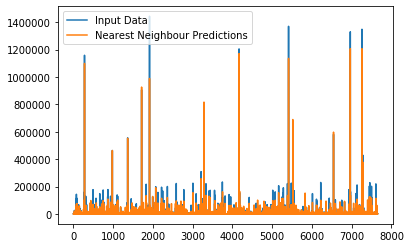

In [68]:
check_results_test(knn_estimator, in_conf_test, out_conf_test, 'Nearest Neighbour Predictions')

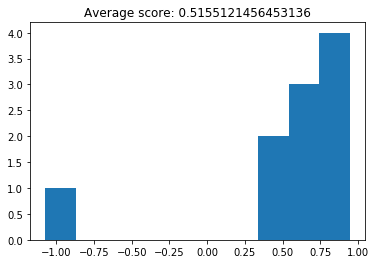

In [69]:
knn_estimator_2 = clone(knn_estimator)

plot_cross_val_score(knn_estimator_2, inputs, outputs, 10)

MAE: 32487.47167487686
MSE: 7604790696.013459
RMSE: 87205.45106823002
R^2: 0.9672231879135582


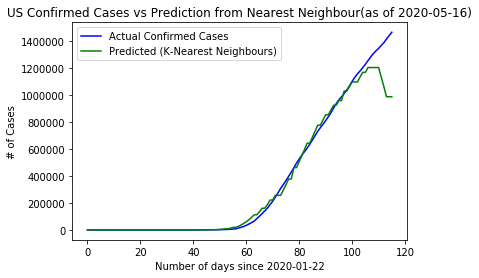

In [70]:
plot_predictions_for_country(
    df, "US", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (K-Nearest Neighbours)", 
    "US Confirmed Cases vs Prediction from Nearest Neighbour"
)

MAE: 31715.05726600985
MSE: 2323395687.767725
RMSE: 48201.614991281414
R^2: 0.7316954345595614


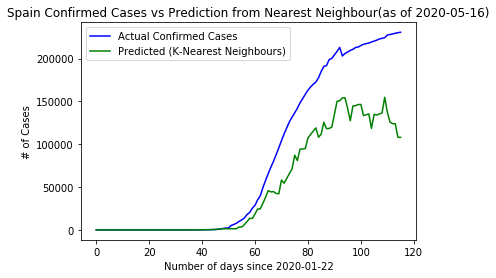

In [71]:
plot_predictions_for_country(
    df, "Spain", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (K-Nearest Neighbours)", 
    "Spain Confirmed Cases vs Prediction from Nearest Neighbour"
)

MAE: 5144.195197044335
MSE: 321336858.6121129
RMSE: 17925.871209291694
R^2: 0.8923730945453854


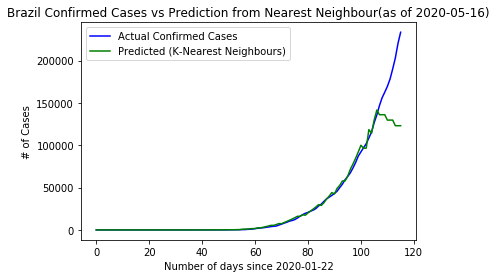

In [72]:
plot_predictions_for_country(
    df, "Brazil", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (K-Nearest Neighbours)", 
    "Brazil Confirmed Cases vs Prediction from Nearest Neighbour"
)

MAE: 24057.80726600985
MSE: 1399360946.3726687
RMSE: 37408.033179688406
R^2: -11.190191741349878


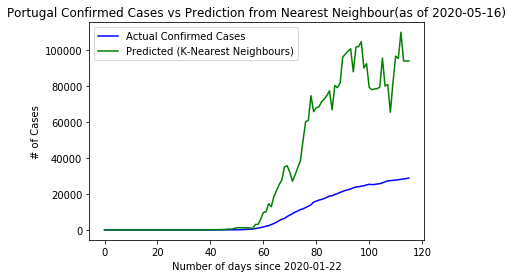

In [73]:
plot_predictions_for_country(
    df, "Portugal", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (K-Nearest Neighbours)", 
    "Portugal Confirmed Cases vs Prediction from Nearest Neighbour"
)

MAE: 4638.478448275861
MSE: 193924140.25347465
RMSE: 13925.664804722059
R^2: 0.9596192208049432


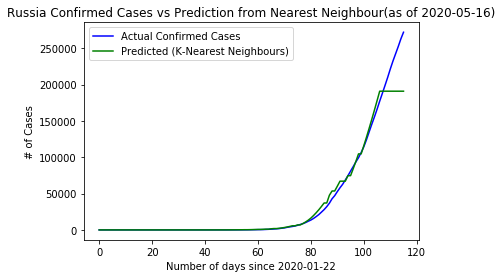

In [74]:
plot_predictions_for_country(
    df, "Russia", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (K-Nearest Neighbours)", 
    "Russia Confirmed Cases vs Prediction from Nearest Neighbour"
)

MAE: 45112.17302955665
MSE: 4280801164.9848256
RMSE: 65427.83173073081
R^2: 0.43253518578499217


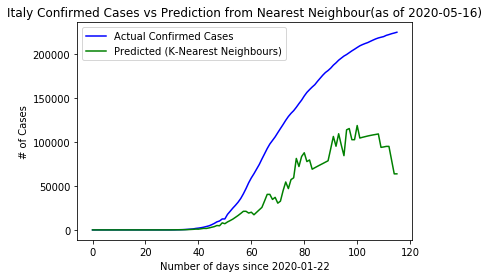

In [75]:
plot_predictions_for_country(
    df, "Italy", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (K-Nearest Neighbours)", 
    "Italy Confirmed Cases vs Prediction from Nearest Neighbour"
)

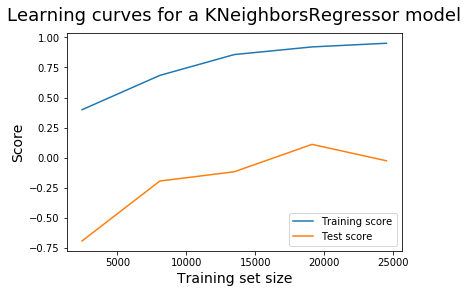

In [76]:
# learning curve
knn_estimator_2 = clone(knn_estimator)

plot_learning_curve(knn_estimator_2, inputs, outputs)

### 3.4.2) Regression for Death Cases
### Using the best combination of parameters found for the confirmed deaths, for K nearest neighbours the best option tested was using increases in confirmed cases and normalized values, using increases as output

In [77]:
# get the inputs of the data for the machine learning algorithm
new_df = df.loc[df["Deaths_inc_day_before_norm"].notna()]

inputs = new_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.68731909, -0.11017732],
       [ 0.79830423, -0.03978737, -1.68731909, -0.11017732],
       [ 1.3112115 , -1.98320106, -1.68731909, -0.11017732],
       ...,
       [-1.47205293,  0.07554281,  1.71718314, -0.11017732],
       [ 0.31790115,  1.38034566,  1.71718314, -0.11017732],
       [-1.65599721,  0.09994051,  1.71718314, -0.11017732]])

In [78]:
outputs = new_df["Deaths_inc"].values
outputs

array([0., 0., 0., ..., 0., 0., 0.])

In [79]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [80]:
# do hyper parameter tuning with the K-Nearest, using cross validation
leaf_size = list(range(10,50))
n_neighbors = list(range(10,30))
p=[1,2]

param_grid = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

search = RandomizedSearchCV(KNeighborsRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
knn_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
knn_estimator

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   17.0s finished


Elapsed time: 0.2918638507525126mins
Best score: -823.7413348841678
Best parameters: {'p': 1, 'n_neighbors': 16, 'leaf_size': 18}


KNeighborsRegressor(algorithm='auto', leaf_size=18, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=16, p=1,
                    weights='uniform')

MAE: 3.240102108036891
MSE: 1116.265404726614
RMSE: 33.410558282175025
R^2: 0.8474634932814372


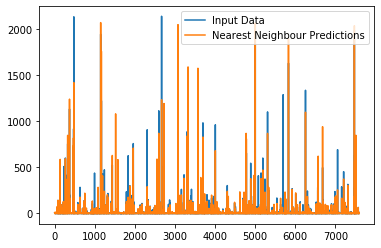

In [81]:
check_results_test(knn_estimator, in_conf_test, out_conf_test, 'Nearest Neighbour Predictions')

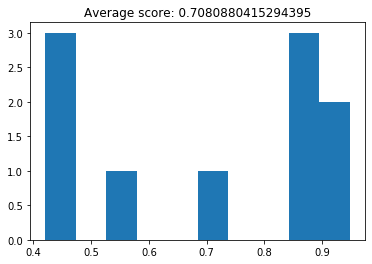

In [82]:
knn_estimator_2 = clone(knn_estimator)

plot_cross_val_score(knn_estimator_2, inputs, outputs, 10)

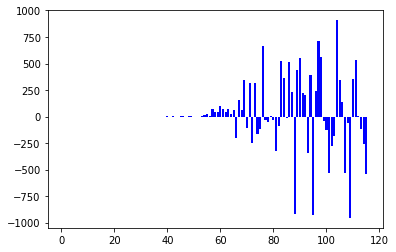

In [83]:
plot_pred_diff(
    new_df, knn_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths_inc"
)

MAE: 1036.065760869565
MSE: 2814349.3247622284
RMSE: 1677.6022546367267
R^2: 0.9965737653964195


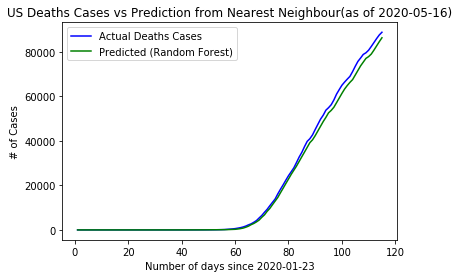

In [84]:
plot_predictions_for_country(
    new_df, "US", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (KNN)", 
    "US Deaths Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 222.2733695652174
MSE: 100570.44249320652
RMSE: 317.12843217410597
R^2: 0.9991000322235585


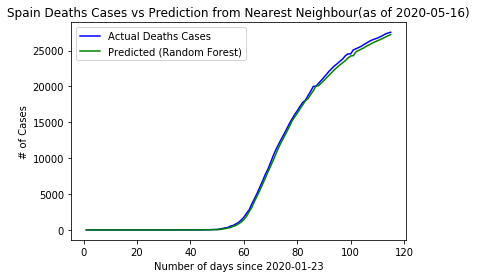

In [85]:
plot_predictions_for_country(
    new_df, "Spain", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (KNN)", 
    "Spain Deaths Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 221.83695652173913
MSE: 258001.31161684782
RMSE: 507.93829508794454
R^2: 0.9818234518339953


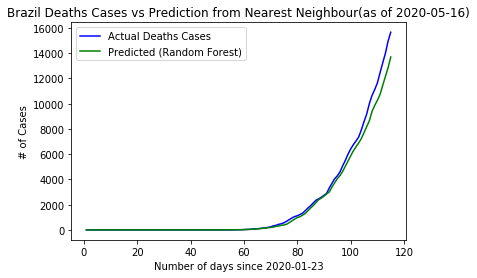

In [86]:
plot_predictions_for_country(
    new_df, "Brazil", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (KNN)", 
    "Brazil Deaths Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 110.425
MSE: 43623.86433423913
RMSE: 208.8632670773852
R^2: 0.761352597421905


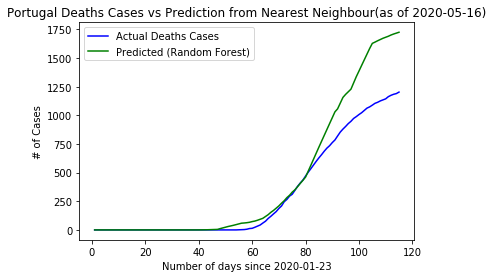

In [87]:
plot_predictions_for_country(
    new_df, "Portugal", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (KNN)", 
    "Portugal Deaths Cases vs Prediction from Nearest Neighbour",
    True
)

In [ ]:
plot_predictions_for_country(
    new_df, "Russia", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (KNN)", 
    "Russia Deaths Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 248.50108695652173
MSE: 115459.03586956521
RMSE: 339.792636573492
R^2: 0.9991935491735702


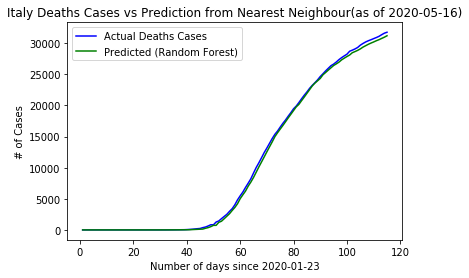

In [88]:
plot_predictions_for_country(
    new_df, "Italy", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (KNN)", 
    "Italy Deaths Cases vs Prediction from Nearest Neighbour",
    True
)

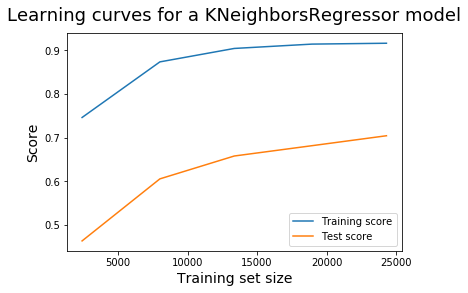

In [90]:
# learning curve
knn_estimator_2 = clone(knn_estimator)

plot_learning_curve(knn_estimator_2, inputs, outputs)

### 3.4.3) Regression for Recovered Cases
### Using the best combination of parameters found for the confirmed deaths, for K nearest neighbours the best option tested was using increases in confirmed cases and normalized values, using cumulative as output

In [91]:
# get the inputs of the data for the machine learning algorithm
new_df = df.loc[df["Recovered_inc_day_before_norm"].notna()]

inputs = new_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.68731909, -0.12137308],
       [ 0.79830423, -0.03978737, -1.68731909, -0.12137308],
       [ 0.27177561, -0.30283255, -1.68731909, -0.12137308],
       ...,
       [-1.47205293,  0.07554281,  1.71718314, -0.12137308],
       [ 0.31790115,  1.38034566,  1.71718314, -0.12137308],
       [-1.65599721,  0.09994051,  1.71718314, -0.12137308]])

In [92]:
outputs = new_df["Recovered_inc"].values
outputs

array([ 0.,  0.,  0., ..., 59.,  0.,  0.])

In [93]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [ ]:
# do hyper parameter tuning with the K-Nearest, using cross validation
leaf_size = list(range(10,50))
n_neighbors = list(range(10,30))
p=[1,2]

param_grid = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

search = RandomizedSearchCV(KNeighborsRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
knn_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
knn_estimator

MAE: 56.255159589328116
MSE: 306864.0982848294
RMSE: 553.95315531625
R^2: 0.14735838969679893


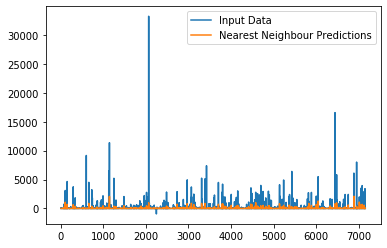

In [94]:
check_results_test(knn_estimator, in_conf_test, out_conf_test, 'Nearest Neighbour Predictions')

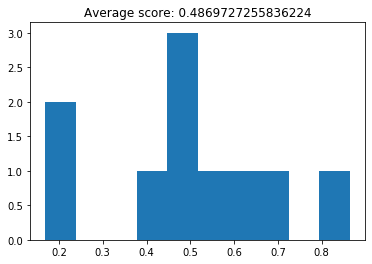

In [96]:
knn_estimator_2 = clone(knn_estimator)

plot_cross_val_score(knn_estimator_2, inputs, outputs, 10)

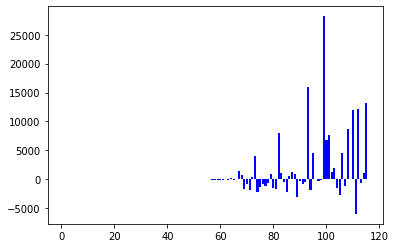

In [97]:
plot_pred_diff(
    new_df, knn_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered_inc"
)

MAE: 11635.221376811594
MSE: 768783855.6091938
RMSE: 27726.951790797233
R^2: 0.8630048673164767


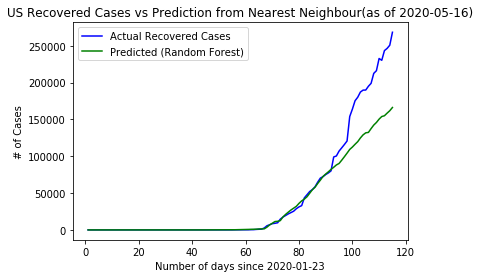

In [98]:
plot_predictions_for_country(
    new_df, "US", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (KNN)", 
    "US Recovered Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 5412.260869565216
MSE: 72100835.4868961
RMSE: 8491.221083383478
R^2: 0.9705463811140943


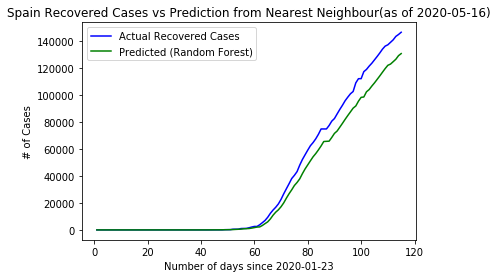

In [99]:
plot_predictions_for_country(
    new_df, "Spain", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (KNN)", 
    "Spain Recovered Cases vs Prediction from Nearest Neighbour",
    True
)

In [ ]:
plot_predictions_for_country(
    new_df, "Brazil", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (KNN)", 
    "Brazil Recovered Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 1130.5300724637682
MSE: 3225416.0240187203
RMSE: 1795.9443265365217
R^2: -2.9640914511235956


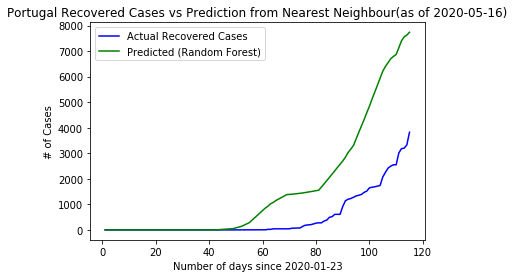

In [100]:
plot_predictions_for_country(
    new_df, "Portugal", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (KNN)", 
    "Portugal Recovered Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 1090.7923913043476
MSE: 7328827.137937797
RMSE: 2707.1806622273657
R^2: 0.9546092091383908


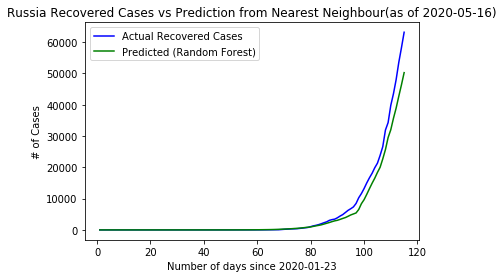

In [102]:
plot_predictions_for_country(
    new_df, "Russia", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (KNN)", 
    "Russia Recovered Cases vs Prediction from Nearest Neighbour",
    True
)

In [ ]:
plot_predictions_for_country(
    new_df, "Italy", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (KNN)", 
    "Italy Recovered Cases vs Prediction from Nearest Neighbour",
    True
)

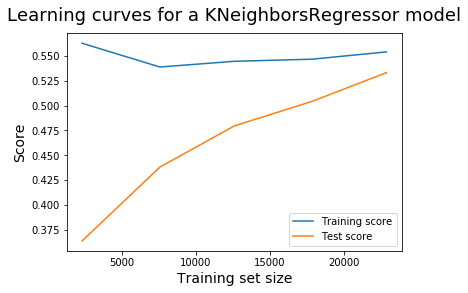

In [103]:
# learning curve
knn_estimator_2 = clone(knn_estimator)

plot_learning_curve(knn_estimator_2, inputs, outputs)